# 1. Loading the model

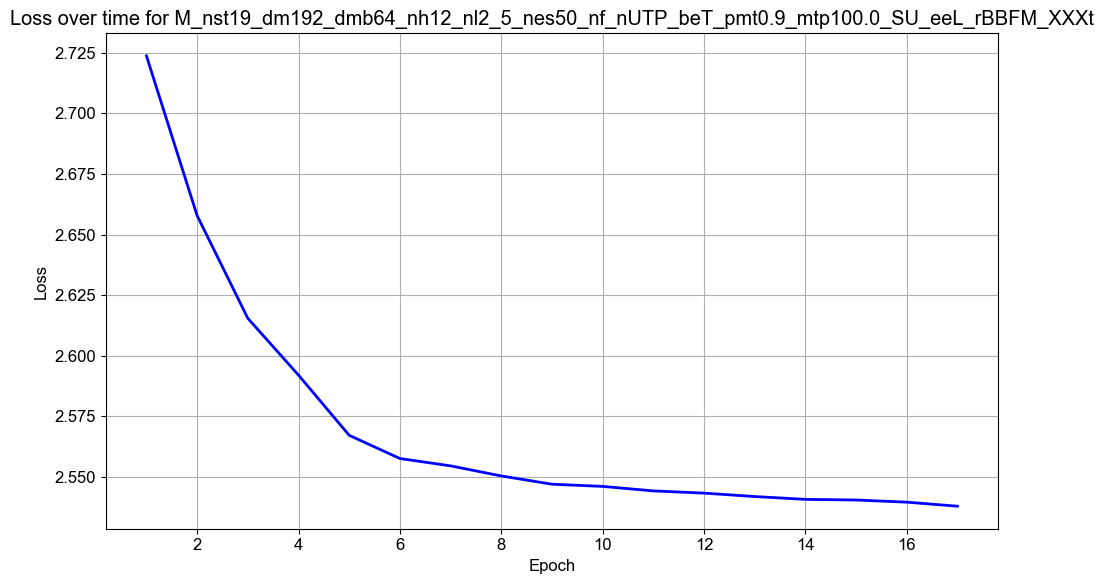

In [1]:
model_dirname = "M_nst1_dm192_nh12_nl5_5_nes50_nf_mxt8_eeL_fb1_cls_lr0.003_lrL_ws100_rBBFM_MM"#"M_nst19_dm192_nh12_nl5_5_nes50_nf_nSP_mxt8_eeL_fb2_cls_lr0.003_rBBFM1_lrL_ws100"
model_dirname = "M_nst1_dm192_nh12_nl5_5_nes50_nf_pmt0.75_psa0.1_mxt8_eeL_fb1_cls_lr0.003_lrL_ws100_rBBFM_MM3_SP"
model_dirname = "M_nst20_dm192_nh12_nl5_5_nSP_eaM_eeL_fb1_cls_lr0.003_rEXP_0513_x"
model_dirname = "M_nst19_dm192_dmb64_nh12_nl2_5_nes50_nf_nUTP_beT_pmt0.9_mtp100.0_SU_eeL_rBBFM_XXXt"

models_data_path = "/om2/user/zaho/bfm_old_fft/bfm/models_data"
models_data_path = "models_data"
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Load the training statistics from the JSON file
stats_path = os.path.join(models_data_path, model_dirname, 'training_statistics.json')

with open(stats_path, 'r') as f:
    training_stats = json.load(f)


losses = [x['test_loss'] for x in training_stats if 'test_loss' in x]
epochs = range(1, len(losses) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, 'b-', linewidth=2)
plt.title(f'Loss over time for {model_dirname}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# Set x-axis to logarithmic scale
#plt.xscale('log')


plt.tight_layout()
plt.show()


In [7]:
import torch
from subject_braintreebank import BrainTreebankSubject

# Define the epoch number
n_epoch = 6

normalize_embeddings = True

# Construct the model path
model_path = os.path.join(models_data_path, model_dirname, f'model_epoch_{n_epoch}.pth')

# Load the model dictionary
model_dict = torch.load(model_path, map_location=torch.device('cpu'))


train_subject_trials = model_dict['training_config']['train_subject_trials']
train_subject_ids = list(set([int(x.split('k')[1]) for x, y in train_subject_trials]))
train_subject_ids
subject_ids = train_subject_ids
all_subjects = {
    subject_id: BrainTreebankSubject(subject_id, cache=False)
    for subject_id in subject_ids
}

# Print the keys in the model dictionary
print("Keys in the model dictionary:")
for key in model_dict.keys():
    print(f"- {key}")

subjects_electrode_embeddings = {}
subjects_electrode_coordinates = {}
for subject_id in subject_ids:
    subject = all_subjects[subject_id]


    electrode_ids = []
    for electrode_label in subject.electrode_labels:
        key = subject.subject_identifier, electrode_label
        
        if 'electrode_embeddings_state_dict' in model_dict:
            electrode_ids.append(model_dict['electrode_embeddings_state_dict']['embeddings_map'][key])
        else:
            electrode_ids.append(model_dict['electrode_data_embeddings_state_dict']['embeddings_map'][key])
    if 'electrode_embeddings_state_dict' in model_dict:
        electrode_embeddings = model_dict['electrode_embeddings_state_dict']['embeddings.weight'][electrode_ids].float()
    else:
        electrode_embeddings = model_dict['electrode_data_embeddings_state_dict'][f'electrode_embedding_class.embeddings.weight'][electrode_ids].float()
    electrode_coordinates = subject.get_electrode_coordinates().float()

    if normalize_embeddings:
        electrode_embeddings = (electrode_embeddings - electrode_embeddings.mean(dim=1, keepdim=True)) / electrode_embeddings.std(dim=1, keepdim=True)
        electrode_embeddings = (electrode_embeddings) / (electrode_embeddings**2).sum(dim=1, keepdim=True)**0.5

    subjects_electrode_embeddings[subject_id] = electrode_embeddings.numpy()
    subjects_electrode_coordinates[subject_id] = electrode_coordinates.numpy()

Keys in the model dictionary:
- eval_results
- epoch
- model_state_dict
- bin_embed_transformer_state_dict
- bin_unembed_transformer_state_dict
- electrode_embeddings_state_dict
- optimizer_state_dicts
- training_config
- model_config
- cluster_config


In [31]:

plot_subject_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]#subject_ids#[7, 3]
plot_subject_ids = [3]#, 4, 7, 10]

# 2. Calculate pairwise distances between electrode coordinates

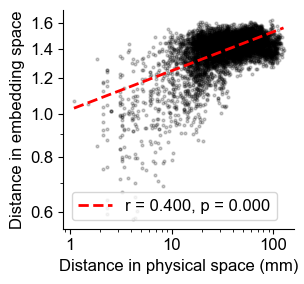

Number of electrode pairs: 7626
Correlation between physical distance and embedding distance: 0.400
p-value: 0.000
Log-log slope: 0.088


In [42]:
# Calculate pairwise distances between electrode coordinates
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise Euclidean distances between electrode coordinates
pairwise_distances = []
pairwise_embedding_distances = []

for subject_id in plot_subject_ids:
    electrode_coordinates_np = subjects_electrode_coordinates[subject_id]
    electrode_embeddings_np = subjects_electrode_embeddings[subject_id]
    n_electrodes = electrode_coordinates_np.shape[0]
    for i in range(n_electrodes):
        for j in range(i+1, n_electrodes):  # Only calculate unique pairs
            # Calculate Euclidean distance between coordinates
            dist = np.linalg.norm(electrode_coordinates_np[i] - electrode_coordinates_np[j])
            
            # Calculate Euclidean distance between embeddings
            embedding_dist = np.linalg.norm(electrode_embeddings_np[i] - electrode_embeddings_np[j])
            
            pairwise_distances.append(dist+0.1)
            pairwise_embedding_distances.append(embedding_dist)

# Convert to numpy arrays
pairwise_distances = np.array(pairwise_distances)
pairwise_embedding_distances = np.array(pairwise_embedding_distances)

# Calculate correlation
correlation, p_value = pearsonr(pairwise_distances, pairwise_embedding_distances)

# Create the log-log scatter plot
plt.figure(figsize=(3.2, 3))
plt.loglog(pairwise_distances, pairwise_embedding_distances, 'o', color='black', alpha=0.2, markersize=2, rasterized=True)
plt.xlabel('Distance in physical space (mm)')
plt.ylabel('Distance in embedding space')

# Add a trend line on log-log scale
log_distances = np.log(pairwise_distances)
log_embedding_distances = np.log(pairwise_embedding_distances)
z = np.polyfit(log_distances, log_embedding_distances, 1)
p = np.poly1d(z)

# Create x points for the trend line
x_log = np.linspace(min(log_distances), max(log_distances), 100)
x = np.exp(x_log)
y = np.exp(p(x_log))

plt.loglog(x, y, "r--", alpha=1.0, linewidth=2, label=f'r = {correlation:.3f}, p = {p_value:.3f}')
plt.legend()

# Set x-ticks to specific values
#yticks = np.arange(0.4, 1.1, 0.2)
#plt.yticks(yticks, labels=[f'{y:.1f}' for y in yticks])

# Remove top and right axes borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Use regular float notation instead of scientific notation
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# Fix x-axis formatting
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.major.formatter._useMathText = False
ax.xaxis.major.formatter._useOffset = False
# Fix y-axis formatting with explicit format to prevent scientific notation
# Get current y-ticks and their positions
yticks = np.arange(0, 2, 0.2)
# Filter out ticks that are outside the data range
yticks = yticks[(yticks >= min(pairwise_embedding_distances)) & 
                (yticks <= max(pairwise_embedding_distances))]
# Set the y-ticks with custom formatting to avoid scientific notation
plt.yticks(yticks, labels=[f'{y:.1f}' for y in yticks])

plt.xticks([1, 10, 100])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout()
subject_id = plot_subject_ids[0]
plt.savefig(f'paper_figures/F5_electrode_embeddings/sub{subject_id}_loglog_correlation_distance_electrodes_{model_dirname}.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"Number of electrode pairs: {len(pairwise_distances)}")
print(f"Correlation between physical distance and embedding distance: {correlation:.3f}")
print(f"p-value: {p_value:.3f}")
print(f"Log-log slope: {z[0]:.3f}")


# 3. Hemisphere plots

In [46]:
from btbench.btbench_config import ROOT_DIR
import pandas as pd

# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

base_path = os.path.join(ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

def plot_hemisphere_axis(electrodes, colors=None, ax=None, hemisphere="left", title=None, vmin=0, vmax=0.1):
    '''
    electrodes is a dict of format {<subject>: [<electrode>]}
    '''
    if colors is None: c = 'white'
    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img)
    elif hemisphere=="right":
        ax.imshow(right_hem_img)
    
    ax.axis('off')
    assert hemisphere in ["left", "right"]
    hem_index = 1 if hemisphere=="left" else 0

    plot_title = f'{hemisphere} hemisphere'
    if title: plot_title += f' {title}'
   
    all_x, all_y, all_colors = [], [], []
    for s in electrodes:
        for e in electrodes[s]:
            x = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['X'])
            y = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['Y'])

            all_x += x
            all_y += y
            all_colors += [colors[e]]*len(x)
            #print(f"for subject {s} and electrode {e} there are {len(x)} points")
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_colors = np.array(all_colors)
    # Sort points by color value so lower values appear on top
    sort_idx = np.argsort(all_colors)[::-1]
    sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=70, edgecolors='black', cmap='viridis_r')
    
def plot_hemispheres_separately(electrodes, ax1, ax2, colors=None, vmin=0, vmax=0.1):
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax1, hemisphere="right", vmin=vmin, vmax=vmax)
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax2, hemisphere="left", vmin=vmin, vmax=vmax)

(124, 192)
Explained variance ratio: [0.07584818 0.07114943]
Total explained variance: 0.1470


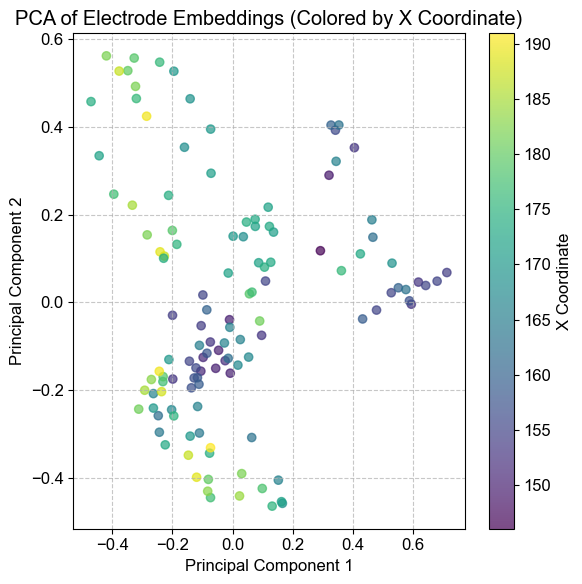

In [34]:
all_electrode_embeddings = np.concatenate([subjects_electrode_embeddings[subject_id] for subject_id in plot_subject_ids])
all_electrode_coordinates = np.concatenate([subjects_electrode_coordinates[subject_id] for subject_id in plot_subject_ids])

# Perform PCA to reduce electrode embeddings to 2 dimensions
from sklearn.decomposition import PCA

print(all_electrode_embeddings.shape)

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the electrode embeddings
electrode_embeddings_2d = pca.fit_transform(all_electrode_embeddings)

# Print explained variance ratio to see how much information is retained
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create a scatter plot of the 2D embeddings colored by electrode coordinates
plt.figure(figsize=(6, 6))

# Use the x-coordinate for coloring
color_values = all_electrode_coordinates[:, 0]  # Using x-coordinate for coloring
scatter = plt.scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                     c=color_values, cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='X Coordinate')
plt.title('PCA of Electrode Embeddings (Colored by X Coordinate)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
all_electrode_embeddings = np.concatenate([subjects_electrode_embeddings[subject_id] for subject_id in plot_subject_ids])
all_electrode_coordinates = np.concatenate([subjects_electrode_coordinates[subject_id] for subject_id in plot_subject_ids])
all_subject_ids = np.concatenate([[subject_id]*len(subjects_electrode_embeddings[subject_id]) for subject_id in plot_subject_ids])

# Perform t-SNE to reduce electrode embeddings to 2 dimensions
from sklearn.manifold import TSNE

print(all_electrode_embeddings.shape)

use_tsne = True
if use_tsne:
    # Initialize t-SNE with 2 components
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    electrode_embeddings_2d = tsne.fit_transform(all_electrode_embeddings)
else:
    pca = PCA(n_components=2)
    electrode_embeddings_2d = pca.fit_transform(all_electrode_embeddings)

# Fit and transform the electrode embeddings

(124, 192)


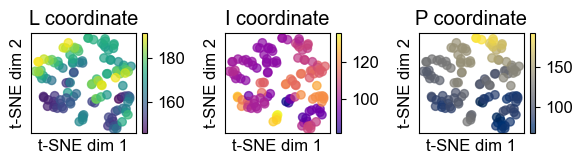

In [50]:
# Create a figure with 3 subplots for L, I, P coordinates
fig, axes = plt.subplots(1, 3, figsize=(6, 1.8))

# Determine the correct title based on the dimensionality reduction method
method_name = "t-SNE" if use_tsne else "PCA"

# Plot for L coordinate (Left-Right)
scatter_L = axes[0].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 0], cmap='viridis', alpha=0.7)
axes[0].set_title(f'L coordinate')
axes[0].set_xlabel(f'{method_name} dim 1')
axes[0].set_ylabel(f'{method_name} dim 2')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.colorbar(scatter_L, ax=axes[0])

# Plot for I coordinate (Inferior-Superior)
scatter_I = axes[1].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 1], cmap='plasma', alpha=0.7)
axes[1].set_title(f'I coordinate')
axes[1].set_xlabel(f'{method_name} dim 1')
axes[1].set_ylabel(f'{method_name} dim 2')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.colorbar(scatter_I, ax=axes[1])

# Plot for P coordinate (Posterior-Anterior)
scatter_P = axes[2].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 2], cmap='cividis', alpha=0.7)
axes[2].set_title(f'P coordinate')
axes[2].set_xlabel(f'{method_name} dim 1')
axes[2].set_ylabel(f'{method_name} dim 2')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.colorbar(scatter_P, ax=axes[2])

plt.tight_layout()
plt.savefig(f'paper_figures/F5_electrode_embeddings/sub{subject_id}_{method_name}_pca_electrodes_{model_dirname}.pdf', bbox_inches='tight', dpi=300)
plt.show()


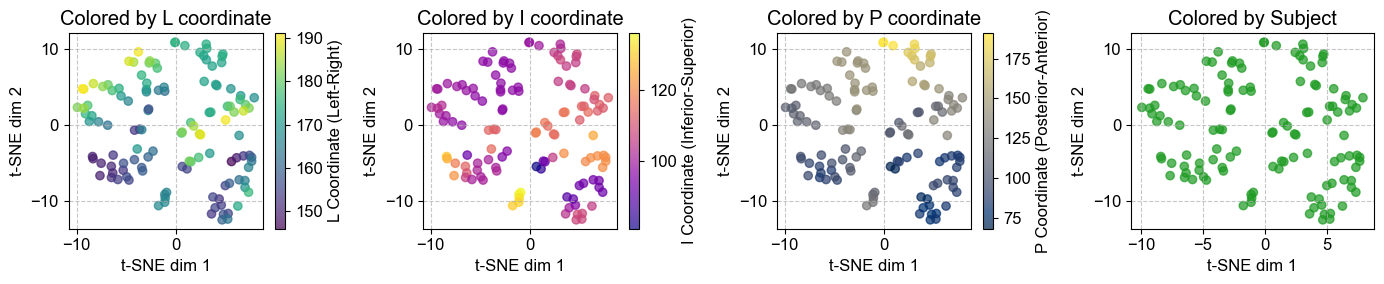

In [37]:
# Create a figure with 3 subplots for L, I, P coordinates
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

# Determine the correct title based on the dimensionality reduction method
method_name = "t-SNE" if use_tsne else "PCA"

# Plot for L coordinate (Left-Right)
scatter_L = axes[0].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 0], cmap='viridis', alpha=0.7)
axes[0].set_title(f'Colored by L coordinate')
axes[0].set_xlabel(f'{method_name} dim 1')
axes[0].set_ylabel(f'{method_name} dim 2')
axes[0].grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter_L, ax=axes[0], label='L Coordinate (Left-Right)')

# Plot for I coordinate (Inferior-Superior)
scatter_I = axes[1].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 1], cmap='plasma', alpha=0.7)
axes[1].set_title(f'Colored by I coordinate')
axes[1].set_xlabel(f'{method_name} dim 1')
axes[1].set_ylabel(f'{method_name} dim 2')
axes[1].grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter_I, ax=axes[1], label='I Coordinate (Inferior-Superior)')

# Plot for P coordinate (Posterior-Anterior)
scatter_P = axes[2].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                          c=all_electrode_coordinates[:, 2], cmap='cividis', alpha=0.7)
axes[2].set_title(f'Colored by P coordinate')
axes[2].set_xlabel(f'{method_name} dim 1')
axes[2].set_ylabel(f'{method_name} dim 2')
axes[2].grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter_P, ax=axes[2], label='P Coordinate (Posterior-Anterior)')

# Plot colored by subject
# Create a dictionary to map subject IDs to colors
import matplotlib.colors as mcolors
import random

# Generate random colors for each subject
np.random.seed(43)  # For reproducibility
subject_colors = {}
for i, subject_id in enumerate(plot_subject_ids):
    subject_colors[subject_id] = np.random.rand(3,)  # Random RGB color

# Create an array of colors based on subject IDs
subject_color_array = np.zeros((len(all_subject_ids), 3))
for i, subject_id in enumerate(all_subject_ids):
    if subject_id in subject_colors:
        subject_color_array[i] = subject_colors[subject_id]

# Plot with subject colors
scatter_subj = axes[3].scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], 
                             c=subject_color_array, alpha=0.7)
axes[3].set_title(f'Colored by Subject')
axes[3].set_xlabel(f'{method_name} dim 1')
axes[3].set_ylabel(f'{method_name} dim 2')
axes[3].grid(True, linestyle='--', alpha=0.7)

# Add a legend for subject colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=subject_colors[subject_id], 
                             markersize=10, label=f'Subject {subject_id}')
                  for subject_id in plot_subject_ids]
# axes[3].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig(f'paper_figures/F5_electrode_embeddings/{method_name}_pca_electrodes_{model_dirname}.pdf', bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_1400646/2704653756.py:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=70, edgecolors='black', cmap='viridis_r')


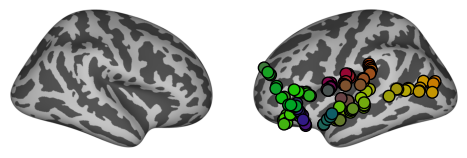

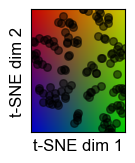

In [52]:
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(1, 2, figsize=(6, 1.8),
                        gridspec_kw={'wspace': 0.1})


# Collect all electrodes across subjects
all_electrodes = {}
for subject_id in plot_subject_ids:
    all_electrodes[f"sub_{subject_id}"] = all_subjects[subject_id].electrode_labels

# Create a colormap based on the 2D embeddings
# Normalize the 2D coordinates to [0,1] range for coloring
min_x, max_x = np.min(electrode_embeddings_2d[:, 0]), np.max(electrode_embeddings_2d[:, 0])
min_y, max_y = np.min(electrode_embeddings_2d[:, 1]), np.max(electrode_embeddings_2d[:, 1])

# Function to generate color from normalized x and y coordinates
def get_color_from_normalized_coords(norm_x, norm_y):
    """
    Generate a color based on normalized x and y coordinates (0-1 range).
    Uses a 2D color scheme with 4 distinct colors in corners and linear interpolation.
    
    Args:
        norm_x: Normalized x coordinate (0-1)
        norm_y: Normalized y coordinate (0-1)
    
    Returns:
        hex_color: Hex string representation of the color
    """
    # Create a 2D colormap using four distinct colors at the corners
    # Bottom-left (0,0), Bottom-right (1,0), Top-left (0,1), Top-right (1,1)
    bottom_left = np.array([0.0, 0.0, 0.8])  # Blue
    bottom_right = np.array([0.0, 0.8, 0.0])  # Green
    top_left = np.array([0.8, 0.0, 0.0])  # Red
    top_right = np.array([0.8, 0.8, 0.0])  # Yellow
    
    # Interpolate between the four corners based on normalized coordinates
    color = (1 - norm_y) * ((1 - norm_x) * bottom_left + norm_x * bottom_right) + \
            norm_y * ((1 - norm_x) * top_left + norm_x * top_right)
    
    # Convert to hex color
    hex_color = "#{:02x}{:02x}{:02x}".format(
        int(color[0] * 255), 
        int(color[1] * 255), 
        int(color[2] * 255)
    )
    
    return hex_color

# Create a color for each electrode based on its 2D position
colors = {}
electrode_idx = 0

for subject_id in plot_subject_ids:
    this_subject_embeddings_2d = electrode_embeddings_2d[electrode_idx:electrode_idx+len(all_subjects[subject_id].electrode_labels)]
    electrode_idx += len(all_subjects[subject_id].electrode_labels)
    norm_x = (this_subject_embeddings_2d[:, 0] - min_x) / (max_x - min_x)
    norm_y = (this_subject_embeddings_2d[:, 1] - min_y) / (max_y - min_y)

    for i, label in enumerate(all_subjects[subject_id].electrode_labels):
        colors[label] = get_color_from_normalized_coords(norm_x[i], norm_y[i])

# Plot all subjects on single pair of hemispheres with PCA-derived colors
plot_hemispheres_separately(all_electrodes, axes[0], axes[1], colors=colors)
plt.savefig(f'paper_figures/F5_electrode_embeddings/sub{subject_id}_hemispheres_electrodes_pca_colored_{model_dirname}.pdf', bbox_inches='tight', dpi=300)

# Create a separate figure to show the PCA colormap
plt.figure(figsize=(2, 1.8))
# Create a grid of points in the normalized PCA space
grid_size = 100
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)

# Create colors for each grid point
grid_colors = np.zeros((grid_size, grid_size, 3))
for i in range(grid_size):
    for j in range(grid_size):
        # Get color components using our function
        hex_color = get_color_from_normalized_coords(X[i, j], Y[i, j])
        # Convert hex to RGB for the grid
        r = int(hex_color[1:3], 16) / 255
        g = int(hex_color[3:5], 16) / 255
        b = int(hex_color[5:7], 16) / 255
        grid_colors[i, j] = [r, g, b]

# Plot the colormap
plt.imshow(grid_colors, origin='lower', extent=[min_x, max_x, min_y, max_y])
plt.scatter(electrode_embeddings_2d[:, 0], electrode_embeddings_2d[:, 1], c='black', alpha=0.5, s=30)
plt.xticks([])
plt.yticks([])
plt.xlabel(f'{method_name} dim 1')
plt.ylabel(f'{method_name} dim 2')
plt.savefig(f'paper_figures/F5_electrode_embeddings/sub{subject_id}_{method_name}_colormap_{model_dirname}.pdf', bbox_inches='tight', dpi=300)
plt.tight_layout()

#plt.savefig('figures/hemispheres_electrodes_pca_colored.pdf', bbox_inches='tight', dpi=300)